In [1]:
import os, random, math

from tqdm import tqdm
from PIL import Image, ImageEnhance, ImageOps
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

from DeepPrint.pretrained import DeepPrintNet
from DeepPrint.dataset import apply_affine_to_map_tensor, DeepPrintDataset

In [14]:
DEBUG = True

In [ ]:
# Scan all samples in both splits:
all_samples = [
    fname[:-4]
    for split in ["training", "validation"]
    for fname in os.listdir(f"../../datasets/fingerprints/{split}/images")
    if fname.endswith('.png')
]
all_ids = sorted({s.split('_')[0] for s in all_samples})


if DEBUG:
    # Limit to the first N classes
    N_CLASSES = 100  # or 1, for the most extreme case
    all_ids = all_ids[:N_CLASSES]

global_id2label = {id_str: i for i, id_str in enumerate(all_ids)}


    
train_all_samples = [
    fname[:-4]
    for fname in os.listdir("../../datasets/fingerprints/training/images")
    if fname.endswith('.png')
]

# Only include samples whose ID is in all_ids (the first N classes)
train_samples = [s for s in train_all_samples if s.split('_')[0] in all_ids]

val_all_samples = [
    fname[:-4]
    for fname in os.listdir("../../datasets/fingerprints/validation/images")
    if fname.endswith('.png')
]

val_samples = [s for s in val_all_samples if s.split('_')[0] in all_ids]

print(len(train_samples), len(val_samples))

500 20


In [4]:
if DEBUG:
    train_set = DeepPrintDataset(root='../../datasets/fingerprints/training', split='train', ids=train_samples, id2label=global_id2label)
    val_set = DeepPrintDataset(root='../../datasets/fingerprints/validation', split='val', ids=val_samples, id2label=global_id2label)
else:
    train_set = DeepPrintDataset(root='../../datasets/fingerprints/training', split='train', id2label=global_id2label)
    val_set = DeepPrintDataset(root='../../datasets/fingerprints/validation', split='val', id2label=global_id2label)

500 images for 100 classes found for train split
20 images for 100 classes found for val split


In [2]:
train_set = DeepPrintDataset(root='../../../dataset-fingerprints/', split='train')
train_loader = DataLoader(train_set, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)

263 images for 6 classes found for train split


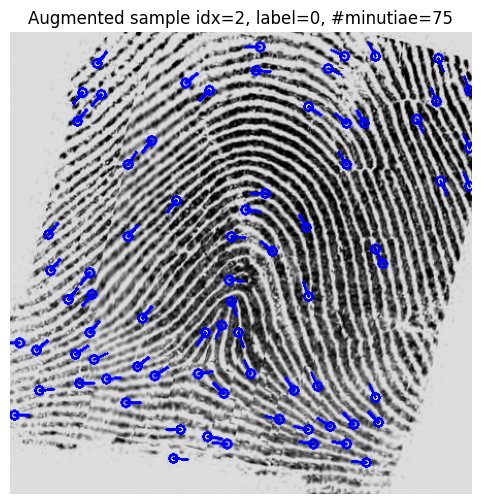

In [3]:
import matplotlib.pyplot as plt
from DeepPrint.display import extract_minutiae_from_map, draw_minutiae_on_image
import cv2

idx = 2
img, label, H = train_set.__getitem__(idx)

img_np = (img.squeeze().numpy() * 255).astype(np.uint8)
map_np = H.permute(1, 2, 0).numpy()
h_img, w_img = img_np.shape
h_map, w_map = H.shape[1], H.shape[2]

# Extract minutiae from map
minutiae = extract_minutiae_from_map(map_np, 0.5, 5)

# Draw on image
img_with_minutiae = draw_minutiae_on_image(img_np, minutiae, map_shape=(h_map, w_map), img_shape=(h_img, w_img))

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(img_with_minutiae, cv2.COLOR_BGR2RGB))
plt.title(f"Augmented sample idx={idx}, label={label}, #minutiae={len(minutiae)}")
plt.axis('off')
plt.show()

In [4]:
# Params for training
num_classes = train_set.num_classes

# Set up GPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print("Using device:", device)
print(f"Found {num_classes} on dataset.")
model = DeepPrintNet(num_classes).to(device)

Using device: cuda
Found 6 on dataset.


In [5]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Apply only to parts that dont have pre-trained weights.
model.minutiae_embed.apply(weights_init)
model.minutiae_map.apply(weights_init)
model.texture_fc.apply(weights_init)
model.classifier1.apply(weights_init)
model.classifier2.apply(weights_init)
model.localization.apply(weights_init)

# # zero localization initial vals
# nn.init.zeros_(model.localization.fc[-1].weight)
# nn.init.zeros_(model.localization.fc[-1].bias)

LocalizationNetwork(
  (down): Upsample(size=(128, 128), mode='bilinear')
  (conv): Sequential(
    (0): Conv2d(1, 24, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=3, bias=True)
  )
)

In [6]:
def balanced_mse_loss(pred, target):
    # foreground: target > 0
    foreground = (target > 0).float()
    background = (target == 0).float()
    # Number of foreground and background pixels
    n_fore = foreground.sum()
    n_back = background.sum()
    # Avoid divide-by-zero
    w_fore = 1.0 / (n_fore + 1e-6)
    w_back = 1.0 / (n_back + 1e-6)
    # Assign weights: usually you want foreground weight to be much higher
    weight = foreground * w_fore + background * w_back
    # Compute weighted loss
    loss = ((pred - target) ** 2) * weight
    # Normalize by total pixels (or sum of weights)
    return loss.sum() / weight.sum()

def balanced_mse_loss_per_sample(pred: torch.Tensor, target: torch.Tensor, eps=1e-6) -> torch.Tensor:
    """
    Balanced MSE loss per sample, with per-image foreground/background weighting.
    Args:
        pred: (B, C, H, W)
        target: (B, C, H, W)
    Returns:
        Scalar loss
    """
    B = pred.size(0)
    losses = []

    for i in range(B):
        p = pred[i]
        t = target[i]

        foreground = (t > 0).float()
        background = (t == 0).float()

        n_fore = foreground.sum()
        n_back = background.sum()

        w_fore = 1.0 / (n_fore + eps)
        w_back = 1.0 / (n_back + eps)

        weight = foreground * w_fore + background * w_back
        loss = ((p - t) ** 2 * weight).sum() / weight.sum()
        losses.append(loss)

    return torch.stack(losses).mean()

class CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim, device='cpu'):
        super().__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim).to(device))

    def forward(self, features, labels):
        # features: [B, feat_dim], labels: [B]
        batch_size = features.size(0)
        centers_batch = self.centers[labels] # [B, feat_dim]
        loss = ((features - centers_batch) ** 2).sum() / batch_size
        return loss
    
def deepprint_loss(
    output,
    labels,
    minutiae_map_gt,
    center_loss_r1,
    center_loss_r2,
    λ1=1.0,
    λ2=0.00125,
    λ3= 0.760, #0.095,
):
    # L1: Cross-entropy on both branches
    loss_ce1 = F.cross_entropy(output['logits1'], labels)
    loss_ce2 = F.cross_entropy(output['logits2'], labels)
    L1 = loss_ce1 + loss_ce2

    # L2: Center loss on both branches
    L2_1 = center_loss_r1(output['R1'], labels)
    L2_2 = center_loss_r2(output['R2'], labels)
    L2 = L2_1 + L2_2

    # L3: Minutiae map MSE
    # L3 = F.mse_loss(output['minutiae_map'], minutiae_map_gt)
    L3 = balanced_mse_loss_per_sample(output['minutiae_map'], minutiae_map_gt)

    # Weighted sum
    total_loss = λ1 * L1 + λ2 * L2 + λ3 * L3

    return total_loss, {'L1': L1.item(), 'L2': L2.item(), 'L3': L3.item()}

In [7]:
base_lr = 0.001  # You can tune this as needed

center_loss_r1 = CenterLoss(num_classes, 96, device=device)
center_loss_r2 = CenterLoss(num_classes, 96, device=device)

#
# Insane optimizer magic to apply different LR
# to different parts of the model.
#
optimizer = torch.optim.RMSprop(
    [
        # Main model params (excluding localization, center loss)
        {'params': [p for n, p in model.named_parameters() if not n.startswith('localization.') and 'center_loss' not in n]},
        # Localization network, scaled LR
        {'params': model.localization.parameters(), 'lr': base_lr * 0.035}, # 0.035
        # Center loss params, scaled LR
        {'params': center_loss_r1.parameters(), 'lr': 0.5 * base_lr},
        {'params': center_loss_r2.parameters(), 'lr': 0.5 * base_lr},
    ],
    lr=base_lr,
    weight_decay=0.00004
)

In [8]:
from torch.utils.tensorboard import SummaryWriter
from DeepPrint.display import extract_minutiae_from_map, draw_minutiae_on_image
import cv2
import time

writer = SummaryWriter("runs/deepprint_exp1")

0it [00:06, ?it/s]


tensor([-0.1633], device='cuda:0', grad_fn=<SelectBackward0>)


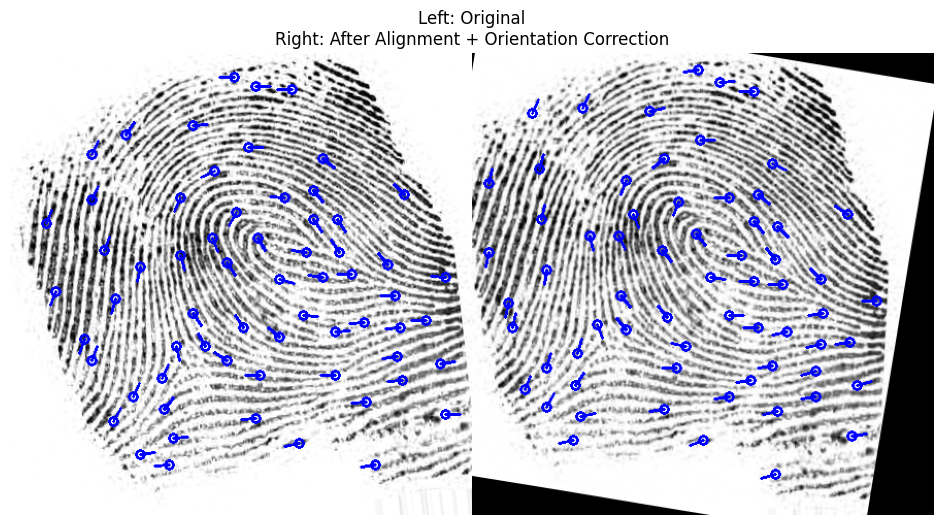

In [22]:
def apply_affine_to_map_tensor(mmap_tensor, dx, dy, dt, img_shape=(448, 448)):
    """
    Batched affine transform on [B, 6, H, W] tensor, followed by channel-wise rotation.
    dx, dy, dt must be shape [B]
    """
    B, C, H, W = mmap_tensor.shape
    assert C == 6, "Expected 6 orientation bins"
    device = mmap_tensor.device
    ih, iw = img_shape

    # Normalize translations
    tx = dx / iw  # [B]
    ty = dy / ih

    cos_theta = torch.cos(dt)  # [B]
    sin_theta = torch.sin(dt)

    # Construct affine matrices for each batch element: [B, 2, 3]
    zeros = torch.zeros_like(tx)
    ones = torch.ones_like(tx)

    affine = torch.stack([
        torch.stack([cos_theta, -sin_theta, tx], dim=1),
        torch.stack([sin_theta,  cos_theta, ty], dim=1)
    ], dim=1)  # shape [B, 2, 3]

    grid = F.affine_grid(affine, mmap_tensor.size(), align_corners=False)
    transformed = F.grid_sample(mmap_tensor, grid, mode='nearest', align_corners=False)

    # Rotate orientation channels
    rotated = rotate_orientation_channels_torch(transformed, dt)
    return rotated

def rotate_orientation_channels_torch(mmap_tensor, delta_theta):
    """
    Rotates the orientation channels of a 6-channel minutiae map tensor (circular shift).

    Args:
        mmap_tensor: torch.Tensor of shape [B, 6, H, W]
        delta_theta: tensor of shape [B], in radians (positive = clockwise)

    Returns:
        Rotated tensor, same shape [B, 6, H, W]
    """
    B, C, H, W = mmap_tensor.shape
    assert C == 6, "Expected 6 orientation bins"
    device = mmap_tensor.device

    shift = -6 * delta_theta / (2 * torch.pi)  # shape [B]

    # DFT over channel dim (dim=1)
    fmap = torch.fft.fft(mmap_tensor, dim=1)

    # Frequency indices (shape [6])
    freqs = torch.fft.fftfreq(C, device=device)  # shape [6]

    # Create per-batch phase shift: [B, 6]
    phase = torch.exp(-2j * torch.pi * freqs.unsqueeze(0) * shift.unsqueeze(1))  # [B, 6]

    # Reshape to broadcast over H, W
    phase = phase.view(B, C, 1, 1)  # [B, 6, 1, 1]

    fmap_shifted = fmap * phase  # [B, 6, H, W] * [B, 6, 1, 1]

    rotated = torch.fft.ifft(fmap_shifted, dim=1).real
    return rotated

train_loader = DataLoader(train_set, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)
tqdm_bar = tqdm(enumerate(train_loader))
for batch_idx, (imgs, labels, maps) in tqdm_bar:
    imgs, labels, maps = imgs.to(device), labels.to(device), maps.to(device)
    outputs = model(imgs)
    break

# ---- Get predicted alignment ----
B, C, H, W = maps.shape
tx = outputs['alignment'][:, 0]
ty = outputs['alignment'][:, 1]
theta = outputs['alignment'][:, 2]
print(theta)

rot_map = apply_affine_to_map_tensor(maps, tx, ty, theta)

# ---- Get input and aligned images (first sample) ----
original_img = imgs[0].detach().cpu().squeeze().numpy()
aligned_img = outputs['aligned'][0].detach().cpu().squeeze().numpy()

original_img_uint8 = (original_img * 255).astype(np.uint8)
aligned_img_uint8 = (aligned_img * 255).astype(np.uint8)

h_img, w_img = aligned_img_uint8.shape
h_map, w_map = H, W

# ---- Extract minutiae ----
minutiae_original = extract_minutiae_from_map(maps[0].permute(1, 2, 0).detach().cpu().numpy(), 0.5)
minutiae_shifted = extract_minutiae_from_map(rot_map[0].permute(1, 2, 0).detach().cpu().numpy(), 0.5)

# ---- Draw overlays ----
img_ori_overlay = draw_minutiae_on_image(original_img_uint8, minutiae_original, map_shape=(h_map, w_map), img_shape=(h_img, w_img))
img_shifted_overlay = draw_minutiae_on_image(aligned_img_uint8, minutiae_shifted, map_shape=(h_map, w_map), img_shape=(h_img, w_img))

# ---- Concatenate and show ----
concat = cv2.hconcat([
    cv2.cvtColor(img_ori_overlay, cv2.COLOR_BGR2RGB),
    cv2.cvtColor(img_shifted_overlay, cv2.COLOR_BGR2RGB)
])

plt.figure(figsize=(12, 6))
plt.imshow(concat)
plt.title("Left: Original\nRight: After Alignment + Orientation Correction")
plt.axis('off')
plt.show()

In [12]:
for name, param in model.localization.named_parameters():
    print(name, param.grad.norm().item() if param.grad is not None else "No grad")

conv.0.weight No grad
conv.0.bias No grad
conv.3.weight No grad
conv.3.bias No grad
conv.6.weight No grad
conv.6.bias No grad
conv.9.weight No grad
conv.9.bias No grad
fc.2.weight No grad
fc.2.bias No grad
fc.4.weight No grad
fc.4.bias No grad


In [23]:
# --- Setup ---
train_loader = DataLoader(train_set, batch_size=5, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(train_set,   batch_size=5, shuffle=False, num_workers=1, pin_memory=True)
center_loss_r1 = center_loss_r1.to(device)
center_loss_r2 = center_loss_r2.to(device)

best_val_loss = float('inf')
out_dir = 'checkpoints'
os.makedirs(out_dir, exist_ok=True)
num_epochs = 20

# --- Gradient Accumulation ---
effective_batch = 30 # 30
real_batch = 5 # 6
accum_steps = effective_batch // real_batch

# --- Tensorboard ---
if DEBUG:
    log_interval = 10
else:
    log_interval = 100

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0.0
    n_train = 0
    optimizer.zero_grad()
    tqdm_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"[Train] Epoch {epoch}/{num_epochs}")
    for batch_idx, (imgs, labels, maps) in tqdm_bar:

        torch.cuda.synchronize()
        time.sleep(0.15)  # sleep for 200ms

        imgs, labels, maps = imgs.to(device), labels.to(device), maps.to(device)
        outputs = model(imgs)

        # # TEMP: Add dummy dependency on align_params
        # dummy_loss = outputs['alignment'].pow(2).sum() * 1e-4
        # total_loss = total_loss + dummy_loss

        # ==== Align the label (minutiae) maps ====
        # we need this for the loss since the input image
        # is already aligned at this point in time
        
        B, C, H, W = maps.shape
        tx = outputs['alignment'][:, 0]
        ty = outputs['alignment'][:, 1]
        theta = outputs['alignment'][:, 2]

        final_maps = apply_affine_to_map_tensor(maps, tx, ty, theta)  

        # === LOSS STEP
        total_loss, loss_parts = deepprint_loss(
            outputs, labels, final_maps, center_loss_r1, center_loss_r2
        )
        (total_loss / accum_steps).backward()

        # print("\n--- Gradients in Localization Network ---")
        # for name, param in model.localization.named_parameters():
        #     if param.grad is None:
        #         print(f"{name}: No grad")
        #     elif torch.all(param.grad == 0):
        #         print(f"{name}: Grad is ZERO")
        #     else:
        #         print(f"{name}: Grad OK")

        train_loss += total_loss.item() * imgs.size(0)
        n_train += imgs.size(0)

        # Step only every accum_steps
        if (batch_idx + 1) % accum_steps == 0 or (batch_idx + 1) == len(train_loader):
            optimizer.step()
            optimizer.zero_grad()

        tqdm_bar.set_postfix({
            'Loss': f"{total_loss.item():.4f}",
            'L1': f"{loss_parts['L1']:.3f}",
            'L2': f"{loss_parts['L2']:.3f}",
            'L3': f"{loss_parts['L3']:.4f}"
        })

        if (batch_idx + 1) % log_interval == 0:
            # Scalars
            global_step = epoch * len(train_loader) + batch_idx
            writer.add_scalar("Loss/train", total_loss.item(), global_step)
            writer.add_scalar("L1/train", loss_parts["L1"], global_step)
            writer.add_scalar("L2/train", loss_parts["L2"], global_step)
            writer.add_scalar("L3/train", loss_parts["L3"], global_step)
            # Learning rate
            for i, param_group in enumerate(optimizer.param_groups):
                writer.add_scalar(f"LR/group_{i}", param_group['lr'], global_step)
            
            # ----- Aligned visualization -----
            # Take first sample in batch
            align_params = outputs['alignment'][0].detach().cpu().numpy()
            tx, ty, theta = align_params
            angle_deg = -np.rad2deg(theta) #FIXME: negative??

            # # log aligment stuff
            # writer.add_scalar("Align/tx_mean", tx.mean().item(), global_step)
            # writer.add_scalar("Align/ty_mean", ty.mean().item(), global_step)
            # writer.add_scalar("Align/tx_std", tx.std().item(), global_step)
            # writer.add_scalar("Align/ty_std", ty.std().item(), global_step)
            # writer.add_scalar("Align/rot_deg_mean", angle_deg.mean().item(), global_step)
            # writer.add_scalar("Align/rot_deg_std", angle_deg.std().item(), global_step)

            # Get the aligned image (output by model, should be in outputs)
            aligned_img = outputs['aligned'][0].detach().cpu().squeeze().numpy()
            aligned_img_uint8 = (aligned_img * 255).astype(np.uint8)
            h_img, w_img = aligned_img_uint8.shape

            # Predicted map is already in aligned space
            map_pred = outputs['minutiae_map'][0].detach().cpu().permute(1,2,0).numpy()  # (192,192,6)
            # Decode minutiae and draw on aligned image
            minutiae_pred = extract_minutiae_from_map(map_pred, threshold=0.5)
            img_overlay_pred = draw_minutiae_on_image(aligned_img_uint8, minutiae_pred, map_pred.shape[:2], aligned_img_uint8.shape)
            img_tb_pred = torch.from_numpy(cv2.cvtColor(img_overlay_pred, cv2.COLOR_BGR2RGB)).permute(2,0,1).float()/255.
            writer.add_image("Train/minutiae_pred_overlay", img_tb_pred, global_step)

            # Aligned GT: apply alignment to GT map
            aligned_map_gd = final_maps[0].detach().cpu().permute(1, 2, 0).numpy()
            minutiae_gd = extract_minutiae_from_map(aligned_map_gd, threshold=0.5)
            img_overlay_gd = draw_minutiae_on_image(aligned_img_uint8, minutiae_gd, aligned_map_gd.shape[:2], aligned_img_uint8.shape)
            img_tb_gd = torch.from_numpy(cv2.cvtColor(img_overlay_gd, cv2.COLOR_BGR2RGB)).permute(2,0,1).float()/255.
            writer.add_image("Train/minutiae_gd_overlay", img_tb_gd, global_step)

            # Get the aligned image (output by model)
            aligned_img = outputs['aligned'][0].detach().cpu().squeeze().numpy()
            aligned_img_uint8 = (aligned_img * 255).astype(np.uint8)

            # Get the original image (input to model, already normalized in range [0,1])
            input_img = imgs[0].detach().cpu().squeeze().numpy()
            input_img_uint8 = (input_img * 255).astype(np.uint8)

            # Convert to 3-channel BGR for drawing
            input_img_bgr = cv2.cvtColor(input_img_uint8, cv2.COLOR_GRAY2BGR)
            aligned_img_bgr = cv2.cvtColor(aligned_img_uint8, cv2.COLOR_GRAY2BGR)

            # Resize to match if needed (usually they will already match)
            if input_img_bgr.shape != aligned_img_bgr.shape:
                aligned_img_bgr = cv2.resize(aligned_img_bgr, (input_img_bgr.shape[1], input_img_bgr.shape[0]))
            
            text = f"tx={tx:.2f}, ty={ty:.2f}, theta={angle_deg:.1f}°"
            cv2.putText(
                aligned_img_bgr,
                text,
                org=(10, 25),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.6,
                color=(0, 255, 0),
                thickness=1,
                lineType=cv2.LINE_AA
            )

            # Concatenate horizontally
            concat_img = cv2.hconcat([input_img_bgr, aligned_img_bgr])
            concat_tb = torch.from_numpy(cv2.cvtColor(concat_img, cv2.COLOR_BGR2RGB)).permute(2,0,1).float() / 255.
            
            writer.add_image("Train/alignment_input_vs_aligned", concat_tb, global_step)

    train_loss /= n_train

    # --- Validation ---
    if DEBUG:
        val_acc = 0.
        val_loss = 999.
    else:
        val_loss = 0.0
        n_val = 0
        correct_top1 = 0
        correct_top1_l1 = 0
        correct_top1_l2 = 0

        with torch.no_grad():
            tqdm_bar = tqdm(val_loader, desc=f"[Val]   Epoch {epoch}/{num_epochs}")
            for imgs, labels, maps in tqdm_bar:

                torch.cuda.synchronize()
                time.sleep(0.15)  # sleep for 200ms

                imgs, labels, maps = imgs.to(device), labels.to(device), maps.to(device)
                outputs = model(imgs)

                total_loss, _ = deepprint_loss(
                    outputs, labels, maps, center_loss_r1, center_loss_r2
                )
                val_loss += total_loss.item() * imgs.size(0)
                n_val += imgs.size(0)

                # Fusion branch (sum or average logits)
                pred = torch.argmax(outputs['logits1'] + outputs['logits2'], dim=1)
                correct_top1 += (pred == labels).sum().item()
                
                # Individual branches
                pred1 = torch.argmax(outputs['logits1'], dim=1)
                pred2 = torch.argmax(outputs['logits2'], dim=1)
                correct_top1_l1 += (pred1 == labels).sum().item()
                correct_top1_l2 += (pred2 == labels).sum().item()

                tqdm_bar.set_postfix({
                    'ValLoss': f"{total_loss.item():.4f}",
                    'Top1-fuse': f"{correct_top1/n_val:.3%}",
                    'Top1-l1': f"{correct_top1_l1/n_val:.3%}",
                    'Top1-l2': f"{correct_top1_l2/n_val:.3%}",
                })

        val_loss /= n_val
        val_acc_fused = correct_top1 / n_val
        val_acc_l1 = correct_top1_l1 / n_val
        val_acc_l2 = correct_top1_l2 / n_val

        print(f"Epoch {epoch}: ValLoss={val_loss:.4f} | ValAcc-fused={val_acc_fused:.3%} | ValAcc-l1={val_acc_l1:.3%} | ValAcc-l2={val_acc_l2:.3%}")

    if DEBUG: 
        correct = 0
        total = 0
        for imgs, labels, maps in tqdm(train_loader):
            imgs, labels, maps = imgs.to(device), labels.to(device), maps.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs['logits1'] + outputs['logits2'], dim=1)
            correct += (preds == labels).sum().item()
            total += imgs.size(0)
        print(f"Train accuracy: {correct / total * 100:.2f}%")

        # with torch.no_grad():
        #     print("loc params (mean, std):", outputs['alignment'].mean(0), outputs['alignment'].std(0))
        #     print("loc params (min, max):", outputs['alignment'].min(0).values, outputs['alignment'].max(0).values)

        # save_concat_aligned_by_class(
        #     outputs['aligned'],  # Should be (B, H, W) or (B, 1, H, W)
        #     labels,              # Class labels (B,)
        #     outdir='./aligned_debug',
        #     batch_idx=epoch
        # )

    #else:
        #eer, threshold = evaluate_eer_on_test(model, torch.device('cuda'), 'dataset/test/images')
        #print(f"EER Test set: {eer} w/ thr: {threshold}")

    # Save last checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'center_r1': center_loss_r1.state_dict(),
        'center_r2': center_loss_r2.state_dict(),
        'val_loss': val_loss,
    }, 'checkpoints/last_checkpoint.pt')

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'center_r1': center_loss_r1.state_dict(),
            'center_r2': center_loss_r2.state_dict(),
            'val_loss': val_loss,
        }, 'checkpoints/best_model.pt')
        print("✅ Best model updated!")

print("Training complete.")

100%|██████████| 53/53 [00:18<00:00,  2.79it/s]


Train accuracy: 22.81%
✅ Best model updated!


100%|██████████| 53/53 [00:15<00:00,  3.46it/s]


Train accuracy: 22.05%


[Train] Epoch 3/20:  77%|███████▋  | 41/53 [00:36<00:10,  1.12it/s, Loss=3.5916, L1=3.343, L2=194.820, L3=0.0071]


KeyboardInterrupt: 

In [ ]:
# --- Setup ---
train_loader = DataLoader(train_set, batch_size=5, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=5, shuffle=False, num_workers=1, pin_memory=True)
center_loss_r1 = center_loss_r1.to(device)
center_loss_r2 = center_loss_r2.to(device)

best_val_loss = float('inf')
out_dir = 'checkpoints'
os.makedirs(out_dir, exist_ok=True)
num_epochs = 20

# --- Gradient Accumulation ---
effective_batch = 30 # 30
real_batch = 5 # 6
accum_steps = effective_batch // real_batch

# --- Tensorboard ---
if DEBUG:
    log_interval = 10
else:
    log_interval = 100

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0.0
    n_train = 0
    optimizer.zero_grad()
    tqdm_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"[Train] Epoch {epoch}/{num_epochs}")
    for batch_idx, (imgs, labels, maps) in tqdm_bar:

        torch.cuda.synchronize()
        time.sleep(0.15)  # sleep for 200ms

        imgs, labels, maps = imgs.to(device), labels.to(device), maps.to(device)
        outputs = model(imgs)

        # # TEMP: Add dummy dependency on align_params
        # dummy_loss = outputs['alignment'].pow(2).sum() * 1e-4
        # total_loss = total_loss + dummy_loss

        # Here we take the aligment output and apply it into the map
        # ==== Align the label (minutiae) maps ====

        B, C, H, W = maps.shape
        tx = outputs['alignment'][:, 0] / W
        ty = outputs['alignment'][:, 1] / H
        theta = outputs['alignment'][:, 2]

        cos_theta = torch.cos(theta)
        sin_theta = torch.sin(theta)

        affine = torch.zeros((B, 2, 3), device=maps.device, dtype=maps.dtype)
        affine[:, 0, 0] = cos_theta
        affine[:, 0, 1] = -sin_theta
        affine[:, 1, 0] = sin_theta
        affine[:, 1, 1] = cos_theta
        affine[:, 0, 2] = tx
        affine[:, 1, 2] = ty

        # ---- Apply alignment to maps ----
        grid = F.affine_grid(affine, size=maps.size(), align_corners=False)
        aligned_maps = F.grid_sample(maps, grid, mode='bilinear', padding_mode='zeros', align_corners=False)

        # Normalize
        max_vals = aligned_maps.view(B, -1).amax(dim=1, keepdim=True).clamp(min=1e-5)
        aligned_maps = aligned_maps / max_vals.view(B, 1, 1, 1)

        # ---- Apply orientation correction ----
        final_maps = shift_minutiae_orientation_bins_torch(aligned_maps, theta)    

        # === LOSS STEP
        total_loss, loss_parts = deepprint_loss(
            outputs, labels, final_maps, center_loss_r1, center_loss_r2
        )
        (total_loss / accum_steps).backward()

        # print("\n--- Gradients in Localization Network ---")
        # for name, param in model.localization.named_parameters():
        #     if param.grad is None:
        #         print(f"{name}: No grad")
        #     elif torch.all(param.grad == 0):
        #         print(f"{name}: Grad is ZERO")
        #     else:
        #         print(f"{name}: Grad OK")

        train_loss += total_loss.item() * imgs.size(0)
        n_train += imgs.size(0)

        # Step only every accum_steps
        if (batch_idx + 1) % accum_steps == 0 or (batch_idx + 1) == len(train_loader):
            optimizer.step()
            optimizer.zero_grad()

        tqdm_bar.set_postfix({
            'Loss': f"{total_loss.item():.4f}",
            'L1': f"{loss_parts['L1']:.3f}",
            'L2': f"{loss_parts['L2']:.3f}",
            'L3': f"{loss_parts['L3']:.4f}"
        })

        if (batch_idx + 1) % log_interval == 0:
            # Scalars
            global_step = epoch * len(train_loader) + batch_idx
            writer.add_scalar("Loss/train", total_loss.item(), global_step)
            writer.add_scalar("L1/train", loss_parts["L1"], global_step)
            writer.add_scalar("L2/train", loss_parts["L2"], global_step)
            writer.add_scalar("L3/train", loss_parts["L3"], global_step)
            # Learning rate
            for i, param_group in enumerate(optimizer.param_groups):
                writer.add_scalar(f"LR/group_{i}", param_group['lr'], global_step)
            
            # ----- Aligned visualization -----
            # Take first sample in batch
            align_params = outputs['alignment'][0].detach().cpu().numpy()
            tx, ty, theta = align_params
            angle_deg = -np.rad2deg(theta) #FIXME: negative??

            # log stuff
            writer.add_scalar("Align/tx_mean", tx.mean().item(), global_step)
            writer.add_scalar("Align/ty_mean", ty.mean().item(), global_step)
            writer.add_scalar("Align/tx_std", tx.std().item(), global_step)
            writer.add_scalar("Align/ty_std", ty.std().item(), global_step)
            writer.add_scalar("Align/rot_deg_mean", angle_deg.mean().item(), global_step)
            writer.add_scalar("Align/rot_deg_std", angle_deg.std().item(), global_step)

            # Get the aligned image (output by model, should be in outputs)
            aligned_img = outputs['aligned'][0].detach().cpu().squeeze().numpy()
            aligned_img_uint8 = (aligned_img * 255).astype(np.uint8)
            h_img, w_img = aligned_img_uint8.shape

            # Predicted map is already in aligned space
            map_pred = outputs['minutiae_map'][0].detach().cpu().permute(1,2,0).numpy()  # (192,192,6)
            # Decode minutiae and draw on aligned image
            minutiae_pred = extract_minutiae_from_map(map_pred, threshold=0.5)
            img_overlay_pred = draw_minutiae_on_image(aligned_img_uint8, minutiae_pred, map_pred.shape[:2], aligned_img_uint8.shape)
            img_tb_pred = torch.from_numpy(cv2.cvtColor(img_overlay_pred, cv2.COLOR_BGR2RGB)).permute(2,0,1).float()/255.
            writer.add_image("Train/minutiae_pred_overlay", img_tb_pred, global_step)

            # Aligned GT: apply alignment to GT map
            aligned_map_gd = final_maps[0].detach().cpu().permute(1, 2, 0).numpy()
            minutiae_gd = extract_minutiae_from_map(aligned_map_gd, threshold=0.5)
            img_overlay_gd = draw_minutiae_on_image(aligned_img_uint8, minutiae_gd, aligned_map_gd.shape[:2], aligned_img_uint8.shape)
            img_tb_gd = torch.from_numpy(cv2.cvtColor(img_overlay_gd, cv2.COLOR_BGR2RGB)).permute(2,0,1).float()/255.
            writer.add_image("Train/minutiae_gd_overlay", img_tb_gd, global_step)

            # Get the aligned image (output by model)
            aligned_img = outputs['aligned'][0].detach().cpu().squeeze().numpy()
            aligned_img_uint8 = (aligned_img * 255).astype(np.uint8)

            # Get the original image (input to model, already normalized in range [0,1])
            input_img = imgs[0].detach().cpu().squeeze().numpy()
            input_img_uint8 = (input_img * 255).astype(np.uint8)

            # Convert to 3-channel BGR for drawing
            input_img_bgr = cv2.cvtColor(input_img_uint8, cv2.COLOR_GRAY2BGR)
            aligned_img_bgr = cv2.cvtColor(aligned_img_uint8, cv2.COLOR_GRAY2BGR)

            # Resize to match if needed (usually they will already match)
            if input_img_bgr.shape != aligned_img_bgr.shape:
                aligned_img_bgr = cv2.resize(aligned_img_bgr, (input_img_bgr.shape[1], input_img_bgr.shape[0]))
            
            text = f"tx={tx:.2f}, ty={ty:.2f}, theta={angle_deg:.1f}°"
            cv2.putText(
                aligned_img_bgr,
                text,
                org=(10, 25),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.6,
                color=(0, 255, 0),
                thickness=1,
                lineType=cv2.LINE_AA
            )

            # Concatenate horizontally
            concat_img = cv2.hconcat([input_img_bgr, aligned_img_bgr])
            concat_tb = torch.from_numpy(cv2.cvtColor(concat_img, cv2.COLOR_BGR2RGB)).permute(2,0,1).float() / 255.
            
            writer.add_image("Train/alignment_input_vs_aligned", concat_tb, global_step)

    train_loss /= n_train

    # --- Validation ---
    if DEBUG:
        val_acc = 0.
        val_loss = 999.
    else:
        val_loss = 0.0
        n_val = 0
        correct_top1 = 0
        correct_top1_l1 = 0
        correct_top1_l2 = 0

        with torch.no_grad():
            tqdm_bar = tqdm(val_loader, desc=f"[Val]   Epoch {epoch}/{num_epochs}")
            for imgs, labels, maps in tqdm_bar:

                torch.cuda.synchronize()
                time.sleep(0.15)  # sleep for 200ms

                imgs, labels, maps = imgs.to(device), labels.to(device), maps.to(device)
                outputs = model(imgs)

                total_loss, _ = deepprint_loss(
                    outputs, labels, maps, center_loss_r1, center_loss_r2
                )
                val_loss += total_loss.item() * imgs.size(0)
                n_val += imgs.size(0)

                # Fusion branch (sum or average logits)
                pred = torch.argmax(outputs['logits1'] + outputs['logits2'], dim=1)
                correct_top1 += (pred == labels).sum().item()
                
                # Individual branches
                pred1 = torch.argmax(outputs['logits1'], dim=1)
                pred2 = torch.argmax(outputs['logits2'], dim=1)
                correct_top1_l1 += (pred1 == labels).sum().item()
                correct_top1_l2 += (pred2 == labels).sum().item()

                tqdm_bar.set_postfix({
                    'ValLoss': f"{total_loss.item():.4f}",
                    'Top1-fuse': f"{correct_top1/n_val:.3%}",
                    'Top1-l1': f"{correct_top1_l1/n_val:.3%}",
                    'Top1-l2': f"{correct_top1_l2/n_val:.3%}",
                })

        val_loss /= n_val
        val_acc_fused = correct_top1 / n_val
        val_acc_l1 = correct_top1_l1 / n_val
        val_acc_l2 = correct_top1_l2 / n_val

        print(f"Epoch {epoch}: ValLoss={val_loss:.4f} | ValAcc-fused={val_acc_fused:.3%} | ValAcc-l1={val_acc_l1:.3%} | ValAcc-l2={val_acc_l2:.3%}")

    if DEBUG: 
        correct = 0
        total = 0
        for imgs, labels, maps in tqdm(train_loader):
            imgs, labels, maps = imgs.to(device), labels.to(device), maps.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs['logits1'] + outputs['logits2'], dim=1)
            correct += (preds == labels).sum().item()
            total += imgs.size(0)
        print(f"Train accuracy: {correct / total * 100:.2f}%")

        # with torch.no_grad():
        #     print("loc params (mean, std):", outputs['alignment'].mean(0), outputs['alignment'].std(0))
        #     print("loc params (min, max):", outputs['alignment'].min(0).values, outputs['alignment'].max(0).values)

        # save_concat_aligned_by_class(
        #     outputs['aligned'],  # Should be (B, H, W) or (B, 1, H, W)
        #     labels,              # Class labels (B,)
        #     outdir='./aligned_debug',
        #     batch_idx=epoch
        # )

    #else:
        #eer, threshold = evaluate_eer_on_test(model, torch.device('cuda'), 'dataset/test/images')
        #print(f"EER Test set: {eer} w/ thr: {threshold}")

    # Save last checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'center_r1': center_loss_r1.state_dict(),
        'center_r2': center_loss_r2.state_dict(),
        'val_loss': val_loss,
    }, 'checkpoints/last_checkpoint.pt')

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'center_r1': center_loss_r1.state_dict(),
            'center_r2': center_loss_r2.state_dict(),
            'val_loss': val_loss,
        }, 'checkpoints/best_model.pt')
        print("✅ Best model updated!")

print("Training complete.")

[Train] Epoch 1/20:  54%|█████▍    | 54/100 [00:36<00:30,  1.50it/s, Loss=11.1793, L1=10.840, L2=267.887, L3=0.0057] 


KeyboardInterrupt: 

In [ ]:
eer, threshold = evaluate_eer_on_test(model, torch.device('cuda'), 'dataset/training/images')
print(f"EER Training set: {eer} w/ thr: {threshold}")

100%|██████████| 1097/1097 [11:07<00:00,  1.64it/s]


EER Test set: 0.4588649442299273 w/ thr: 0.8379426002502441


In [ ]:
eer, threshold = evaluate_eer_on_test(model, torch.device('cuda'), 'dataset/validation/images')
print(f"EER Test set: {eer} w/ thr: {threshold}")

100%|██████████| 56/56 [00:32<00:00,  1.71it/s]


EER Test set: 0.4199951906031279 w/ thr: 0.8651828169822693


: 

In [ ]:

def get_embeddings(dataset, model):
    embeddings = []
    labels = []
    model.eval()
    with torch.no_grad():
        for img, label, _ in DataLoader(dataset, batch_size=5):
            img = img.to(device)
            emb = model(img)['R1']  # or ['R2']
            embeddings.append(emb.cpu())
            labels.append(label)
    embeddings = torch.cat(embeddings)
    labels = torch.cat(labels)
    return embeddings, labels

# Get all embeddings and labels
embeddings, labels = get_embeddings(train_set, model)

# Compute cosine similarity matrix
cosine_sim = torch.nn.functional.cosine_similarity(
    embeddings.unsqueeze(1), embeddings.unsqueeze(0), dim=-1
).cpu().numpy()

# Now, cosine_sim[i, j] is the similarity between sample i and j
# Visualize or compute ROC, EER, etc.

import matplotlib.pyplot as plt
plt.imshow(cosine_sim, cmap='coolwarm')
plt.colorbar()
plt.title('Embedding Cosine Similarity Matrix')
plt.show()

In [ ]:
norms = np.linalg.norm(embeddings, axis=1)
print("Norms mean/std:", norms.mean(), norms.std())